[View in Colaboratory](https://colab.research.google.com/github/marnovo/deep-learning-indaba-2018/blob/master/2018-09-09-s1-Practical_0_5_Machine_Learning_Basics.ipynb)

# Practical 0.5: Machine Learning Basics

## Introduction
In this practical, we introduce the idea of classification (sorting things into categories) using a machine-learning model. We explore the relationship between a classifier's parameters and the decision boundary (a line that separates categories) and also introduce the idea of a loss function. Finally, we briefly introduce Tensorflow.

## Learning Objectives 
* Understand the idea of **classification**
* Understand the concept of (linear) **separability** of a dataset.
* Understand what the **parameters** of a classifier are and how they relate to the **decision boundary**
* Be able to briefly explain what **Tensorflow** is.

In [1]:
#@title [RUN ME!] Imports { display-mode: "form" }
!pip install -q moviepy
!pip install -q imageio
from __future__ import absolute_import, division, print_function

import tensorflow as tf
import numpy as np                 # Numpy is an efficient linear algebra library.
import matplotlib.pyplot as plt    # Matplotlib is used to generate plots of data.
from matplotlib import animation, rc

from IPython import display

try:
  tf.enable_eager_execution()
  print('Running eagerly')
except ValueError:
  print('Already running eagerly')
  
tfe = tf.contrib.eager

Running eagerly


## Outline
In this practical, we tackle the task of **classification** of a simple, synthetic dataset. Classification in machine learning involves learning a labelling of examples into one (or more) discrete categories. This differs from another common task in machine learning called **regression**, which involves learning a mapping from inputs to a continuous-valued output. 

1. We begin by introducing a synthetic dataset of red and blue points which we want to separate
2. We introduce and explore the idea of **linear seperability**
3. We define a **loss** as a measure of how good of a seperator a particular line is
4. We briefly introduce TensorFlow and show how it can be used to automatically find the minimum of a loss function.

In [0]:
#@title [RUN ME!] Helper functions { display-mode: "form" }
def plot_dataset(inputs, labels):
  # Plot the given 2D inputs and labels using Matplotlib.   
  plt.scatter(
      inputs[:, 0], inputs[:, 1], 
      c=['red' if label > 0 else 'blue' for label in labels])

  plt.axis('equal')

  plt.xlabel('x1')
  plt.ylabel('x2')

## The Data

Run the code in the cell below, and look at the resulting plot. It should produce a simple 2-D data set consisting of 2 classes of points, the classes are represented by colours blue and red. Our task is to build a **binary classifier** that can distinguish between red and blue points (red and blue are referred to as the **classes** of the points), using only the 2-D coordinates of a point. In other words, we want a function that takes as input a 2-D vector representing the coordinates of a point and returns a value of 1 or 0 indicating whether the point is red or blue. Here we have **encoded** the colours red and blue into the numbers 1 and 0 (which make it easier to work with in maths and code!)

Note: we have arbitrarily encoded red as 1 and blue as 0, you could do it the other way around too as long as you're consistent!

--- red_inputs ---
 [[ 2.62434536  0.38824359]
 [ 0.47182825 -0.07296862]
 [ 1.86540763 -1.3015387 ]
 [ 2.74481176  0.2387931 ]
 [ 1.3190391   0.75062962]
 [ 2.46210794 -1.06014071]
 [ 0.6775828   0.61594565]
 [ 2.13376944 -0.09989127]
 [ 0.82757179  0.12214158]
 [ 1.04221375  1.58281521]
 [-0.10061918  2.14472371]
 [ 1.90159072  1.50249434]
 [ 1.90085595  0.31627214]
 [ 0.87710977  0.06423057]
 [ 0.73211192  1.53035547]
 [ 0.30833925  0.60324647]
 [ 0.3128273   0.15479436]
 [ 0.32875387  0.9873354 ]
 [-0.11731035  1.2344157 ]
 [ 2.65980218  1.74204416]]
--- blue_inputs ---
 [[-1.19183555 -1.88762896]
 [-1.74715829  0.6924546 ]
 [-0.94919225 -1.63699565]
 [-0.80908452  1.10025514]
 [-0.87984105 -0.38279689]
 [-0.69982968 -1.35224985]
 [-2.1425182  -1.34934272]
 [-1.20889423 -0.41337681]
 [-0.16101659 -0.06889792]
 [-0.71441267 -0.11485884]
 [-1.75439794  0.25286816]
 [-0.48707018 -1.29809284]
 [-0.51148185 -1.07557171]
 [ 0.13162939  0.51981682]
 [ 1.18557541 -2.39649634]
 [-2.44411381

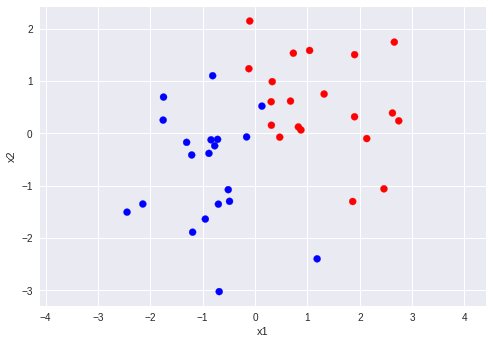

In [16]:
#@title Generate the Dataset  {run: "auto"}
# Define the centre(s) of the points
centre = 1    #@param {type:"slider", min:0, max:2, step:0.1}

points_in_class = 20  # How many points we want per class

# A fixed random seed is a common "trick" used in ML that allows us to recreate
# the same data when there is a random element involved. 
np.random.seed(1)  

# Generate random points in the "red" class
red_inputs = np.random.normal(loc=centre, scale=1.0, size=[points_in_class, 2])     
# Generate random points in the "blue" class
blue_inputs = np.random.normal(loc=-centre, scale=1.0, size=[points_in_class, 2])    
# Put these together
inputs = np.concatenate((red_inputs, blue_inputs), axis=0) 
    
# The class (label) is 1 for red or 0 for blue
red_labels = np.ones(points_in_class)    
blue_labels = np.zeros(points_in_class)
labels = np.concatenate((red_labels, blue_labels), axis=0)

print("--- red_inputs ---\n", red_inputs)
print("--- blue_inputs ---\n", blue_inputs)
print("--- red_labels ---\n", red_labels)
print("--- blue_labels ---\n", blue_labels)
print("--- labels ---\n", labels)

# num_data_points is the total data set size
num_data_points = 2 * points_in_class

plot_dataset(inputs, labels)

###What does the data look like? 
The inputs are 2-dimensional vectors (points in a 2-D space). Here are the coordinates of 4 points, which we've deliberately chosen so that points 1 and 2 are "red" and points 3 and 4 are "blue". 

In [6]:
print('Input 1:\t', inputs[0])
print('Input 2:\t', inputs[1])

print('Input 3:\t', inputs[-1])
print('Input 4:\t', inputs[-2])

Input 1:	 [2.76405235 1.40015721]
Input 2:	 [1.97873798 3.2408932 ]
Input 3:	 [-1.31155253 -0.94383466]
Input 4:	 [-1.87079715 -1.57884966]


The labels are either 0 or 1. Here are the labels corresponding to the points above:

In [0]:
print('Label 1:\t', labels[0])
print('Label 2:\t', labels[1])

print('Label 3:\t', labels[-1])
print('Label 4:\t', labels[-2])

### Aside: Other Examples of Binary Classification Problems

In this practical, we are using a synthetic dataset where we have 2 classes of 2-D points that come from different distributions, distinguised by the colours, red and blue. To make this more concrete, here are some examples of more real-world binary classification problems.

* Determine whether an email message (input) is SPAM or NOT SPAM (label)
* Determine whether an image, represented by its encoded pixel values (input) is a picture of a DOG or a CAT (label)
* Determine whether energy usage of a building will go UP or DOWN (label) next month, using a time series of past energy usage values (input)


## Linear separability

Linear separability of a D-dimensional dataset with 2 classes means that there exists a single (D-1)-dimensional (hyper-)plane that separates the classes (a hyperplane is a generalisation of a straight line to many dimensions). In this case, the dataset is 2-dimensional and is **linearly separable** if it is possible to draw a (1-D) line between the red and blue points such that all of the red points lie on one side of the line and all of the blue points on the other. 

### Exploratory Task
In the code cell under the heading "The Data", change the slider for the ```centre``` value. This will automatically update the value in the code and will redraw the plot.

* At what value of centre does the dataset become linearly separable?


### Question for discussion
Can you think of some 2-D, 2-class datasets, similar to the one above, that are separable (the points from the 2 classes don't overlap each other), but are not **linearly** separable? Draw some examples on paper or plot them using Matplotlib and discuss this with your neighbour and tutors. 



## Drawing the line

As you may recall from school, a line in 2 dimensions, with coordinate axes $x_1$ and $x_2$, which passes through the origin (0, 0) can be represented by the equation $w_1x_1 + w_2x_2 = 0$

We can also write this in vector form as: $\mathbf{w}^T\mathbf{x} = 0$, where $\mathbf{w}^T = [w_1, w_2]$ and $\mathbf{x}^T = [x_1, x_2]$.

When a line (or hyperplane) is defined this way, we call the **parameters**, $\mathbf{w} = (w_1, w_2)$ a **normal vector** for the line. The normal vector is orthogonal (perpendicular) to the line. We want to construct such a line that separates red and blue  points, which we will call a **decision boundary**. 

In the following cell, we plot our dataset along with a normal vector $\mathbf{w}$ and decision boundary. You can adjust the values of $w_1$ and $w_2$ by using the sliders on the right. Observe the effect that the values have on the normal vector drawn in *red* and decision boundary in *black*. Adjust the values so that the black line separates the blue and red points (i.e. red points on one side and blue on the other). Your line should also have the normal vector pointing in the direction of the red points. The reason that direction is significant is that we want to eventually **classify** points on one side of the line as being red and the other as being blue. 

Is it possible to find a line through the origin that perfectly separates the points?

**Note**: Each of our inputs is a 2-D vector, made up of two coordinate values. We refer to these 2 coordinate axes as $x_1$ and $x_2$. For example, if we have an input $(1, 2)$, then we would say $x_1 = 1$ and $x_2 = 2$ for that point.

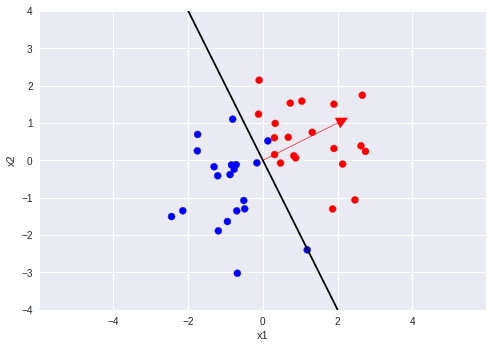

In [29]:
#@title Effect of parameters {run: "auto"}

# Define the parameters
w1 = 2 #@param { type: "slider", min: -5, max: 5, step: 0.1 }
w2 = 1 #@param { type: "slider", min: -5, max: 5, step: 0.1 }

plot_dataset(inputs, labels)

# Add the weight vector to the plot. We plot it in red, as it has to "point"
# in the direction of the red points.
ax = plt.axes()
ax.arrow(0, 0, w1, w2, head_width=0.3, head_length=0.3, fc='r', ec='r')

# Plot part of the decision boundary in black. It is orthogonal to the weight
# vector.
t = 2
plt.plot([-t * w2, t * w2], [t * w1, -t * w1], 'k-')

plt.xlim([-4, 4])
plt.ylim([-4, 4])

plt.show()

## Classification
Given a normal vector $\mathbf{w}$, we can evaluate which side of the decision boundary a particular point $\mathbf{x_i} = (x_{i,1}, x_{i, 2})$ lies by evaluating $\mathbf{w^Tx_i}$. If $\mathbf{w^Tx_i} > 0$, the point $\mathbf{x_i}$ lies to one side of the boundary (in the direction of the normal vector), and we can classify that point as belonging to class 1 (in our case, "red"). If $\mathbf{w^Tx_i} < 0$ the point lies on the other side and can be classified as class 0 (in our case, "blue"). Finally if $\mathbf{w^Tx_i} = 0$ the point lies on the decision boundary and we can decide whether to classify it as either 0 or 1, or ignore it. 

## How "good" is the line?

If you've played around with the above code, you may have developed some intuition around how different settings of the parameters influence the final placement of the decision boundary. The purpose of machine learning is to *automatically* adjust the values of $w_1$ and $w_2$ to find a suitable decision boundary! But to do this, we need to mathematically specify some **loss** or **objective** function. The loss is a function of the parameters $w_1$ and $w_2$ and tells us how good a certain configuration of the parameter values are at classifying the data. This function is defined such that it reaches its optimum setting when it is minimised, i.e. the *smaller* its value, the *better* the separation between the classes. An additional property a loss function can have that is often crucial for machine learning is being *differentiable*. A differentiable loss function allows us to use *gradient-based optimisation* to find its minimum and the corresponding optimal values of $w_1$ and $w_2$. 

For this classification problem, we consider the **binary cross-entropy** loss function to measure how good the model's predictions are.  This loss function compares the model's prediction for each example, $\mathbf{x_i}$ to the true **target** $y_i$ (we often refer to the true label associated with an input as the "target"). It then applies the non-linear log function to penalise the model for being further from the true class. The equation for the binary cross entropy loss, on a dataset with $N$ points is:

\begin{align}
l(\mathbf{w}) = -\frac{1}{N}\sum_{i=1}^N y_i log(\hat{y}_i) + (1-y_i)log(1-\hat{y}_i)
\end{align}

where $\hat{y}_i = \operatorname{sigmoid}(\mathbf{w}^T\mathbf{x_i})$ and the $\operatorname{sigmoid}$ function is defined as:

$$
\mathrm{sigmoid}(a) = \frac{1}{1 + e^{-a}} .
$$

The reason we use the $\operatorname{sigmoid}$ function is because our classifier can output any real value. The binary cross entropy loss function, however, expects the predictions made by a classifier to be between $0$ and $1$. The sigmoid function "squashes" any real number inputs to lie in the interval $(0, 1)$.

Let's now wrap this in a Python function so that we can compute the loss for any values of $w_1$ and $w_2$:



In [0]:
def compute_loss(w1, w2):
  
  total_log_likelihood = 0  
  
  # Add the contribution of each datapoint to the loss
  for (x1, x2), target in zip(inputs, labels):
    # As our targets are 0 or 1, our prediction function must output a value between 0 and 1.
    # The sigmoid function 'squashes' any value to lie between 0 and 1:
    prediction = tf.sigmoid(w1*x1 + w2*x2)  
    
    # Compute the local loss term
    # We add 1e-10 to make the log operations numerically stable (i.e. avoid taking the log of 0.)
    log_likelihood = target * tf.log(prediction + 1e-10) + (1.-target)*tf.log(1.-prediction + 1e-10)
    total_log_likelihood += log_likelihood
  
  loss = -total_log_likelihood
  average_loss = loss / len(inputs)
  return average_loss

### More on the sigmoid function



The sigmoid function is defined as
$$
\mathrm{sigmoid}(a) = \frac{1}{1 + e^{-a}} .
$$
Can you show that
$$
1 - \mathrm{sigmoid}(a) = \frac{1}{1 + e^{a}} ,
$$
and draw both of these on a sheet of paper?

* What is its value when $a = \mathbf{w}^{T}\mathbf{x}$ is positive? negative? and zero?
* What happends to its value when  $a = \mathbf{w}^{T}\mathbf{x}$ becomes larger?
* What is the value of $\mathrm{sigmoid}(\mathbf{w^Tx})$ when $\mathbf{w}^T\mathbf{x} = 0$? How does this change how we classify points on either side of the decision boundary?

After working through the above questions, explain to your neighbour why the binary cross-entropy loss function makes sense. 

**HINT**: Remember the idea of the loss function is to return small values when the classifier makes good predictions and large values when the classifier makes bad predictions. 

### Bonus Question
We derived the `compute_loss()` function above based on minimising the log-loss of the prediction error. This is related to a concept called 'cross-entropy'. But another way of deriving exactly the same loss function is by maximising the likelihood of the data under the model $P(y | x, w_1, w_2)$. If you are familiar with this concept (eg. from statistics), see if you can derive it this way as well.

### Optional Further Reading
More information on the [cross-entropy loss](http://ml-cheatsheet.readthedocs.io/en/latest/loss_functions.html) and another interesting connection to [information theory](https://rdipietro.github.io/friendly-intro-to-cross-entropy-loss/).

## Loss value for your chosen $w_1$ and $w_2$


The following line of code computes the loss value for your chosen values of $w_1$ and $w_2$. Try changing the values of $w_1$ and $w_2$ using the sliders above and rerun the line below. Can you see how a better separation results in a lower loss? 

Note: If you've used TensorFlow before, it might be confusing how this code cell works! We explain more about this later... 

In [21]:
compute_loss(w1, w2).numpy()

0.16179699942074477

## Visualising the loss function

We can visualise the loss function for our dataset by plotting its value at every point in a whole grid of $w_1$ and $w_2$ parameter values. We do this using a **contour plot**, which is a technique for visualising a 3-D function on a 2-D plot by letting colour represent the third dimension. All of the points with the same colour have the same loss value. 

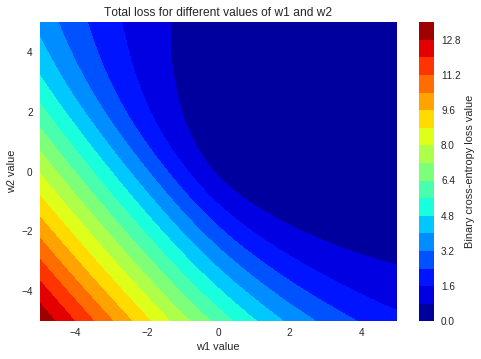

In [0]:
# We define a function so we can re-use this code later
def plot_contours():  
  # Generate a whole bunch of (w1, w2) points in a grid
  ind = np.linspace(-5, 5, 50)
  w1grid, w2grid = np.meshgrid(ind, ind)

  # Compute the loss for each point in the grid
  losses = []
  for w1s, w2s in zip(w1grid, w2grid):
    loss = compute_loss(w1s, w2s)
    losses.append(loss)

  # Pack the loss values for every value of w1 & w2 into one (50,50) array
  losses_array = np.concatenate(losses).reshape(50,50)

  # Now plot the resulting loss function as a contour plot over the whole grid of (w1, w2) values.
  fig = plt.figure()
  plt.contourf(w1grid, w2grid, losses_array, 20, cmap=plt.cm.jet)
  cbar = plt.colorbar()
  cbar.ax.set_ylabel('Binary cross-entropy loss value')
  plt.xlabel('w1 value')
  plt.ylabel('w2 value')
  plt.title('Total loss for different values of w1 and w2')

plot_contours()

## Optimising the loss using TensorFlow

Now that we have a function that gives us the loss for different values of $w_1$ and $w_2$, we want an automated method to find the values that minimise the loss function. This is where optimisation by **gradient descent** comes in. The idea is that for each (batch of) data points, we compute the loss using the current values of $w_1$ and $w_2$ on the data. We then compute the **gradient** (or derivative) of the loss function at the current values of $w_1$ and $w_2$. The negative of the gradient points in the direction of *steepest descent* along the loss function. By adjusting the values of $w_1$ and $w_2$ in the direction of the negative gradient, we move closer towards the minimum of the loss function (provided the loss function is "well behaved"). How big of a step we take is mediated by the **learning rate**. To do this more easily, we will use TensorFlow.

Don't worry if you don't understand what's going on here, you will see this in a lot more detail during the **Mathematics for Machine Learning** lectures!



### Aside: TensorFlow

TensorFlow (TF) is an open source software library for numerical computation using the concept of Tensors. You can think of Tensors as being a generalisation of matrices to higher dimensions, or roughly equivalent to multi-dimensional arrays. Scalars are 0-dimensional tensors, vectors are 1-dimensional, standard matrices are 2-dimensional, and higher-dimensional tensors have 3 or more dimensions. You can think of dimensions as representing groups of numbers that mean the same thing. For example, for images, we often use 3-dimensional tensors where the first dimension represents the red, green, and blue color channels of the image, and the next two are the columns and rows of pixels of the image. 

**Note**: Don't be confused when people say "2-D vector" or "3-D vector", which refers to a 1-dimensional tensor that has size 2 or 3.

The major advantage of using TensorFlow is that it can automatically derive the gradients of many mathematical expressions involving tensors. It achieves this through a process called "automatic differentiation". Tensorflow also supports multiple "kernels", allowing you to easily run your code on normal processors (CPUs), graphics cards (GPUs) and other more exotic hardware accelerators like Google's Tensor Processing Units (TPUs)

Tensorflow actually provides **two modes of operation**, the first, called "graph mode", builds a computation graph upfront and then feeds data into the graph. By building the graph upfront, Tensorflow can apply optimisations to the graph that allow it to extract peak performance from the hardware you're running on. You will have encountered this mode if you used Tensorflow before or attended the Indaba last year! The second mode, called ["Eager-mode"](https://www.tensorflow.org/guide/eager), is a lot newer and evaluates Tensor operations imperatively (in the order you write them), similar to NumPy and PyTorch. Eager-mode is slightly less performant but a lot more intuitive, especially if you've never used a "define-and-run" programming style (like graph mode) before, and is therefore the mode we will use in these practicals. 

### Using Tensorflow to optimise the loss
We use TensorFlow to optimise the parameters of the model with gradient descent. We loop over the dataset multiple times (called "epochs") and plot the final decision boundary along with a plot showing how the parameters and loss changed over the epochs.

**Note**: TensorFlow is probably overkill for this example, becaue the gradient is very easy to calculate, but we introduce it here because it will become essential to calculate the gradients of more complex models in later practicals! 

In [0]:
lr = 0.25  # The learning rate

# Initialise Tensorflow variables representing our parameters.
# We need to use TensorFlow variables here rather than Numpy or Python ones so 
# that TensorFlow is able to compute gradients.
w1 = tfe.Variable(-2.0)  
w2 = tfe.Variable(-4.0)  

plot_contours()

# Loop over the dataset multiple times
parameter_values = []
for epoch in range(20):
  plt.scatter(w1.numpy(), w2.numpy(), marker='o', color='black')
  
  with tf.GradientTape() as tape:
    loss = compute_loss(w1, w2)
  
  # Now we take a step in parameter space in the direction of the gradient to move the parameters closer (hopefully!) to their optimum
  dw1, dw2 = tape.gradient(loss, [w1, w2])
  
  # Step 'lr units' in the direction of the negative gradient
  # We achieve this by subtracting lr * dw1 and lr * dw2 from the w1 and w2 variables
  w1.assign_sub(lr*dw1)
  w2.assign_sub(lr*dw2)
  
print('Finished optimisation, the final values of w1 and w2 are:')
print(w1.numpy(), w2.numpy())

# Plot the final point on the loss surface.
plt.scatter(w1.numpy(), w2.numpy(), marker='x', color='red')
plt.show()

# Plot the final decision boundary
plot_dataset(inputs, labels)
ax = plt.axes()
ax.arrow(0, 0, w1.numpy(), w2.numpy(), head_width=0.3, head_length=0.3, fc='r', ec='r')
plt.plot([-2 * w2.numpy(), 2 * w2.numpy()], [2 * w1.numpy(), -2 * w1.numpy()], 'k-')

plt.xlim([-4, 4])
plt.ylim([-4, 4])

plt.show()

How did the final values of $w_1$ and $w_2$ found by Tensorflow correspond to the ones you found manually? 

## Optional Tasks
If you've worked through this practical, answered all the questions and feel you have a good understanding of what's going on, try the following tasks:

1. Add a **bias** parameter to the equation for the decision boundary and visualise how that changes the decision boundary, the loss and the ultimate solution found by Tensorflow.
2. Add a **regulariser**, for example, the L2 regulariser (see the appendix below for more information) - how does it affect the contour plot of the parameters vs the loss? How does changing the strength of regularisation affect the loss? 

Note: The benefit of using regularisation will be discussed in the next practical! 

# Next Steps
Have a look at [last year's practical](https://github.com/deep-learning-indaba/practicals2017/blob/master/practical1.ipynb) which takes a more "bottom-up" approach, covers more detail on how gradients are computed and also looks at a multi-class classification problem with a non-linear decision boundary. 

Note: last year's practicals use Tensorflow's "graph mode" as opposed to "Eager mode" that we use here.

# Appendix

### L1 and L2 Regularisation

Two of the most simple regularization methods are L1 and L2 regularization (you may have heard of them as _Lasso_ and _Ridge_ regression if you've used linear regression before). Both of these methods regularize the model by adding a term to the loss that penalizes the model if it becomes too complex.
L1 regularization adds a term based on the L1 norm:

$loss_{L1} = loss + \lambda \sum_i |w_i|$

where $\lambda$ is a parameter that controls the amount of regularization, and $w_i$ are the parameters of the model. L1 regularization has the effect of forcing some parameters to shrink to 0, effectively removing them from the model.

L2 regularization similarly adds a term based on the L2 norm:

$loss_{L2} = loss + \lambda \sum_i w_i^2$.

L2 regularization has the effect of preventing any of the parameters from becoming too large and _overpowering_ the others. 

In some cases it can work well to use both L1 and L2 regularization. 

For more information see the articles [here](http://enhancedatascience.com/2017/07/04/machine-learning-explained-regularization/) and [here](https://towardsdatascience.com/l1-and-l2-regularization-methods-ce25e7fc831c).